# Fine Tuning Transformer for Summary Generation

In [1]:
# ! pip install transformers -q
# ! pip install wandb -q
# ! pip install datasets
# ! pip install SentencePiece
# ! pip install nltk
# ! pip install rouge-score
#! pip install evaluate
# Code for TPU packages install

# !curl -q https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
# !python pytorch-xla-env-setup.py --apt-packages libomp5 libopenblas-dev

In [2]:
# Importing stock libraries
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from datasets import load_dataset

# Importing the T5 modules from huggingface/transformers
from transformers import T5Tokenizer, T5ForConditionalGeneration

# WandB – Import the wandb library
import wandb

In [3]:
# Checking out the GPU we have access to. This is output is from the google colab version.
!nvidia-smi

Wed Oct 18 10:25:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    26W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# # Setting up the device for GPU usage
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(f"Device Found : {device}")


Device Found : cuda


In [5]:
# Login to wandb to log the model run and all the parameters
!wandb login

wandb: Currently logged in as: shashi-vish123 (nus-nlp). Use `wandb login --relogin` to force relogin


### Custom Dataset

In [6]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, dataset, tokenizer, source_max_length, target_max_length):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.source_max_length = source_max_length
        self.target_max_length = target_max_length

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        item = self.dataset[index]

        # Concatenate all columns into a single source_text
        source_text = f"Generate Cover Letter for Role: {item['Job Title']}, Preferred Qualifications: {item['Preferred Qualifications']}, \
                        Hiring Company: {item['Hiring Company']}, User Name: {item['Applicant Name']}, \
                        Past Working Experience: {item['Past Working Experience']}, \
                        Current Working Experience: {item['Current Working Experience']}, \
                        Skillsets: {item['Skillsets']}, Qualifications: {item['Qualifications']}"

        #print("Input Source Row : " , source_text)
        target_text = item['Cover Letter']

        # Tokenize and encode the source and target text
        source_tokens = self.tokenizer.encode_plus(
            source_text,
            max_length=self.source_max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt',
        )
        target_tokens = self.tokenizer.encode_plus(
            target_text,
            max_length=self.target_max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt',
        )

        source_ids = source_tokens['input_ids'].squeeze()
        source_mask = source_tokens['attention_mask'].squeeze()
        target_ids = target_tokens['input_ids'].squeeze()
        target_mask = target_tokens['attention_mask'].squeeze()

        return {
            'source_ids': source_ids,
            'source_mask': source_mask,
            'target_ids': target_ids,
            'target_mask': target_mask,
        }


### Train and Validate

In [7]:
def train(epoch, tokenizer, model, device, loader, optimizer):
    model.train()
    for _,data in enumerate(loader, 0):
        y = data['target_ids'].to(device, dtype = torch.long)
        y_ids = y[:, :-1].contiguous()
        lm_labels = y[:, 1:].clone().detach()
        lm_labels[y[:, 1:] == tokenizer.pad_token_id] = -100
        ids = data['source_ids'].to(device, dtype = torch.long)
        mask = data['source_mask'].to(device, dtype = torch.long)

        outputs = model(input_ids = ids, attention_mask = mask, decoder_input_ids=y_ids, labels=lm_labels)
        loss = outputs[0]

        wandb.log({"Epoc ": epoch})

        if _%10 == 0:
            wandb.log({"Training Loss": loss.item()})

        if _%500==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # xm.optimizer_step(optimizer)
        # xm.mark_step()

In [8]:
def validate(epoch, tokenizer, model, device, loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for _, data in enumerate(loader, 0):
            y = data['target_ids'].to(device, dtype = torch.long)
            ids = data['source_ids'].to(device, dtype = torch.long)
            mask = data['source_mask'].to(device, dtype = torch.long)

            generated_ids = model.generate(
                input_ids = ids,
                attention_mask = mask,
                max_length=2048,
                num_beams=2,
                repetition_penalty=2.5,
                length_penalty=1.0,
                early_stopping=True
                )
            preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
            target = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True)for t in y]
            if _%100==0:
                print(f'Completed {_}')

            predictions.extend(preds)
            actuals.extend(target)
            #break # Predict for only on record . Remove this break later.
    return predictions, actuals

### Init Training Config

In [9]:
# tokenzier for encoding the text
tokenizer = T5Tokenizer.from_pretrained("t5-small" , model_max_length=512)

# Download Dataset

dataset = load_dataset("ShashiVish/cover-letter-dataset")
huggingface_train_dataset = dataset['train']
huggingface_test_dataset = dataset['test']

input_max_len = 0
for item in huggingface_train_dataset:
  source_text = f"Generate Cover Letter for Role: {item['Job Title']}, Preferred Qualifications: {item['Preferred Qualifications']}, \
                        Hiring Company: {item['Hiring Company']}, User Name: {item['Applicant Name']}, \
                        Past Working Experience: {item['Past Working Experience']}, \
                        Current Working Experience: {item['Current Working Experience']}, \
                        Skillsets: {item['Skillsets']}, Qualifications: {item['Qualifications']}"
  input_ids = tokenizer.encode(source_text, add_special_tokens=True)
  input_max_len = max(input_max_len, len(input_ids))
for item in huggingface_test_dataset:
  source_text = f"Generate Cover Letter for Role: {item['Job Title']}, Preferred Qualifications: {item['Preferred Qualifications']}, \
                        Hiring Company: {item['Hiring Company']}, User Name: {item['Applicant Name']}, \
                        Past Working Experience: {item['Past Working Experience']}, \
                        Current Working Experience: {item['Current Working Experience']}, \
                        Skillsets: {item['Skillsets']}, Qualifications: {item['Qualifications']}"
  input_ids = tokenizer.encode(source_text, add_special_tokens=True)
  input_max_len = max(input_max_len, len(input_ids))

output_max_len = 0
for item in huggingface_train_dataset:
  source_text = item['Cover Letter']
  input_ids = tokenizer.encode(source_text, add_special_tokens=True)
  output_max_len = max(output_max_len, len(input_ids))
for item in huggingface_test_dataset:
  source_text = item['Cover Letter']
  input_ids = tokenizer.encode(source_text, add_special_tokens=True)
  output_max_len = max(output_max_len, len(input_ids))

print('Input Max sentence length: ', input_max_len)
print('Output Max sentence length: ', output_max_len)



You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Input Max sentence length:  355
Output Max sentence length:  378


In [10]:

wandb.init(project="transformers_cover_letter_t5_large")

# WandB – Config is a variable that holds and saves hyperparameters and inputs
# Defining some key variables that will be used later on in the training
config = wandb.config          # Initialize config
config.TRAIN_BATCH_SIZE = 5  # input batch size for training (default: 64)
config.VALID_BATCH_SIZE = 2    # input batch size for testing (default: 1000)
config.TRAIN_EPOCHS = 50        # number of epochs to train (default: 10)
config.VAL_EPOCHS = 1
config.LEARNING_RATE = 0.0001    # learning rate (default: 0.01)
config.SEED = 42               # random seed (default: 42)
config.MAX_LEN = 512
config.COVER_LETTER_MAX_LEN = 512

# Set random seeds and deterministic pytorch for reproducibility
torch.manual_seed(config.SEED) # pytorch random seed
np.random.seed(config.SEED) # numpy random seed
torch.backends.cudnn.deterministic = True


wandb: Currently logged in as: shashi-vish123 (nus-nlp). Use `wandb login --relogin` to force relogin


In [11]:
train_dataset = CustomDataset(huggingface_train_dataset, tokenizer, config.MAX_LEN, config.COVER_LETTER_MAX_LEN)
test_dataset = CustomDataset(huggingface_test_dataset, tokenizer, config.MAX_LEN, config.COVER_LETTER_MAX_LEN)

# Defining the parameters for creation of dataloaders
train_params = {
    'batch_size': config.TRAIN_BATCH_SIZE,
    'shuffle': True,
    'num_workers': 0
    }

val_params = {
    'batch_size': config.VALID_BATCH_SIZE,
    'shuffle': False,
    'num_workers': 0
    }

# Creation of Dataloaders for testing and validation. This will be used down for training and validation stage for the model.
training_loader = DataLoader(train_dataset, **train_params)
val_loader = DataLoader(test_dataset, **val_params)


# Create Model
#model = T5ForConditionalGeneration.from_pretrained("t5-base")
model = T5ForConditionalGeneration.from_pretrained('t5-small' , max_length = 512)
model = model.to(device)

    # # Defining the optimizer that will be used to tune the weights of the network in the training session.
optimizer = torch.optim.Adam(params =  model.parameters(), lr=config.LEARNING_RATE)

# # Log metrics with wandb
wandb.watch(model, log="all")
# # Training loop
print('Initiating Fine-Tuning for the model on our dataset')

Initiating Fine-Tuning for the model on our dataset


### Start Training

In [12]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

for epoch in range(config.TRAIN_EPOCHS):
  train(epoch, tokenizer, model, device, training_loader, optimizer)


Total number of parameters: 60506624
Epoch: 0, Loss:  4.511571884155273
Epoch: 1, Loss:  1.9921925067901611
Epoch: 2, Loss:  1.4229897260665894
Epoch: 3, Loss:  1.4114959239959717
Epoch: 4, Loss:  1.1223963499069214
Epoch: 5, Loss:  1.370335340499878
Epoch: 6, Loss:  1.211732029914856
Epoch: 7, Loss:  1.6056514978408813
Epoch: 8, Loss:  1.2711933851242065
Epoch: 9, Loss:  1.0595053434371948
Epoch: 10, Loss:  1.3161394596099854
Epoch: 11, Loss:  0.9234535694122314
Epoch: 12, Loss:  1.3876432180404663
Epoch: 13, Loss:  1.0461903810501099
Epoch: 14, Loss:  0.9227286577224731
Epoch: 15, Loss:  0.7419286966323853
Epoch: 16, Loss:  1.0134004354476929
Epoch: 17, Loss:  0.9858090877532959
Epoch: 18, Loss:  0.8356467485427856
Epoch: 19, Loss:  0.9319932460784912
Epoch: 20, Loss:  0.9417433142662048
Epoch: 21, Loss:  0.7405712008476257
Epoch: 22, Loss:  0.38131600618362427
Epoch: 23, Loss:  0.9960192441940308
Epoch: 24, Loss:  0.7162007093429565
Epoch: 25, Loss:  0.44102784991264343
Epoch: 26, L

### Upload Model to HuggingFace

In [17]:
from huggingface_hub import login
login()

In [18]:
model_path = 't5-small-fine-tune-cover-letter'
repo_path = "ShashiVish/"+model_path
# Save Model
model.save_pretrained(model_path)

from huggingface_hub import HfApi
api = HfApi()
api.create_repo(repo_id=model_path)

api.upload_folder(
    folder_path=model_path,
    repo_id=repo_path
)


pytorch_model.bin:   0%|          | 0.00/242M [00:00<?, ?B/s]

'https://huggingface.co/ShashiVish/t5-small-fine-tune-cover-letter/tree/main/'

In [19]:
from transformers import AutoTokenizer
tokenizer.push_to_hub(repo_path)

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ShashiVish/t5-small-fine-tune-cover-letter/commit/f16cc5823f82d7b2083af093c9ddf3f10d373563', commit_message='Upload tokenizer', commit_description='', oid='f16cc5823f82d7b2083af093c9ddf3f10d373563', pr_url=None, pr_revision=None, pr_num=None)

### Download and Evaluate Model

In [13]:

# Load model directly
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

def get_predictions(tokenizer, model, device, val_loader):
  predictions, actuals = validate(1, tokenizer, model, device, val_loader)
  return predictions, actuals


### Calculate Score

In [14]:
import evaluate

def get_accuracy_score(predictions, actuals):
  # Calculate BLEU Score

  bleu = evaluate.load('bleu')
  rouge = evaluate.load('rouge')

  score = {}

  results = rouge.compute(predictions=predictions, references=actuals)
  bleu_results =  bleu.compute(predictions=predictions, references=actuals)

  score['bleu'] = bleu_results['bleu']
  score['rouge1'] = results['rouge1']
  score['rouge2'] = results['rouge2']
  score['rougeL'] = results['rougeL']
  score['rougeLsum'] = results['rougeLsum']

  return score



In [15]:
# Evaluate and generate score
tokenizer = T5Tokenizer.from_pretrained(repo_path)
model = T5ForConditionalGeneration.from_pretrained(repo_path , max_length = 2048)
model = model.to(device)

predictions, actuals = get_predictions(tokenizer, model, device, val_loader)
after_fine_tuning =  get_accuracy_score(predictions, actuals)

print("Final Score After Fine Tunning" , after_fine_tuning)

tokenizer_base = T5Tokenizer.from_pretrained("t5-small")
model_base = T5ForConditionalGeneration.from_pretrained('t5-small' , max_length = 2048)
model_base = model_base.to(device)

predictions_base, actuals_base = get_predictions(tokenizer_base, model_base, device, val_loader)
before_fine_tuning =  get_accuracy_score(predictions_base, actuals_base)

print("Final Score Before Fine Tunning" , before_fine_tuning)


Completed 0
Completed 100


Final Score After Fine Tunning {'bleu': 0.3773320120634749, 'rouge1': 0.6678725875068361, 'rouge2': 0.515660164040101, 'rougeL': 0.5513365142028691, 'rougeLsum': 0.5523071823869528}


In [16]:
model_base = T5ForConditionalGeneration.from_pretrained('t5-base' , max_length = 2048)
total_params = sum(p.numel() for p in model_base.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 222903552


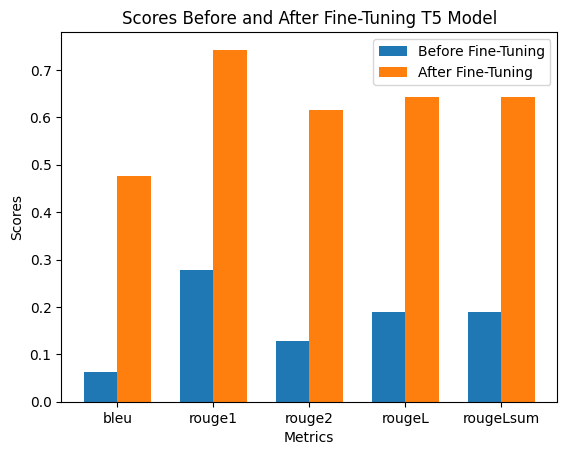

In [ ]:
import matplotlib.pyplot as plt

# Metrics and their corresponding scores
metrics = list(before_fine_tuning.keys())
before_scores = list(before_fine_tuning.values())
after_scores = list(after_fine_tuning.values())

# Create a bar chart
fig, ax = plt.subplots()
width = 0.35
x = range(len(metrics))

ax.bar(x, before_scores, width, label='Before Fine-Tuning')
ax.bar([i + width for i in x], after_scores, width, label='After Fine-Tuning')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Scores Before and After Fine-Tuning T5 Model')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(metrics)
ax.legend()

plt.show()


### Predict for Individual Input

In [ ]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

# Load the tokenizer
tokenizer = T5Tokenizer.from_pretrained(repo_path)
model = T5ForConditionalGeneration.from_pretrained(repo_path , max_length = 4096)

# Set the device for inference (CPU or GPU)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

job_title = "Senior Java Developer"
preferred_qualification = "3+ years of Java, Spring Boot"
hiring_company_name = "Google"
user_name = "Emily Evans"
past_working_experience= "Java Developer at XYZ for 4 years"
current_working_experience = "Senior Java Developer at ABC for 1 year"
skilleset= "Java, Spring Boot, Microservices, SQL, AWS"
qualification = "Master's in Electronics Science"

input_text = f" Generate Cover Letter for Role: {job_title}, \
 Preferred Qualifications: {preferred_qualification}, \
 Hiring Company: {hiring_company_name}, User Name: {user_name}, \
 Past Working Experience: {past_working_experience}, Current Working Experience: {current_working_experience}, \
 Skillsets: {skilleset}, Qualifications: {qualification} "

# Tokenize and generate predictions
input_ids = tokenizer.encode(input_text, return_tensors='pt', max_length=2048, truncation=False, padding=True)
input_ids = input_ids.to(device)
output_ids = model.generate(input_ids)

# Decode the output
output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

print("Generated Cover Letter:")
print(output_text)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Generated Cover Letter:
I am excited to apply for the Senior Java Developer position at Google. I have over three years of experience in Java and Spring Boot and have worked as a Java Developer at XYZ and a Senior Java Developer at ABC. I have a strong understanding of Java, Spring Boot, Microservices, SQL, and AWS. I hold a Master's degree in Electronics Science. I am eager to bring my technical skills and passion for software development to Google.
